# 爬取农业农村部三产融合政策法规并可视化

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import os

import jieba
import jieba.analyse as analyse
import wordcloud
import matplotlib.pyplot as plt
from pyecharts import options as opts
from pyecharts.charts import Page, WordCloud
from pyecharts.globals import SymbolType

# 获取政策文件列表

## 获取政策名称、链接和发布日期

In [2]:
url = "http://www.moa.gov.cn/ztzl/scw/zcfgnc/"
html = requests.get(url)
html.encoding = 'utf-8'
soup = BeautifulSoup(html.text, 'lxml')

# 存储获取政策名称、链接和发布日期
policies = soup.find_all('li', 'li_cir')
title = [policies[i].find('a')['title'] for i in range(len(policies))]
links = [url + policies[i].find('a')['href'][2:] for i in range(len(policies))]
date = [re.sub("\n|\s", "", policies[i].find('span', 'date fr dc_3').text)
        for i in range(len(policies))]

## 结果导出为CSV

In [3]:
info = pd.DataFrame([title, links, date]).T
info.columns = ['文件名称', '链接', '发布日期']
info.to_csv("01_产业融合政策列表.csv", index=None, encoding='utf-8-sig')
info

,文件名称,链接,发布日期
0,农村一二三产业融合助力乡村振兴,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201806/t...,2018-06-15
1,农业农村部关于实施农村一二三产业融合发展推进行动的通知,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201806/t...,2018-06-07
2,农业农村部关于开展休闲农业和乡村旅游升级行动的通知,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201804/t...,2018-04-18
3,返乡下乡人员创业创新政策实问实答,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201703/t...,2017-03-31
4,人社部4项政策鼓励科技人员创新创业：事业单位技术人员创业“留职不停薪”,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201703/t...,2017-03-28
5,人社部关于支持和鼓励事业单位专业技术人员创新创业的指导意见,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201703/t...,2017-03-28
6,农业部等六部门联合实施开发农业农村资源支持农民工等人员返乡创业行动计划,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201701/t...,2017-01-16
7,国务院办公厅关于支持返乡下乡人员创业创新促进农村一二三产业融合发展的意见,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201611/t...,2016-11-29
8,关于印发农村产业融合发展试点示范方案的通知,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201611/t...,2016-11-29
9,国务院办公厅关于推进农村一二三产业融合发展的指导意见,http://www.moa.gov.cn/ztzl/scw/zcfgnc/201611/t...,2016-11-29


# 爬取政策内容

## 爬取产业融合相关的政策

In [4]:
for i in range(len(policies)):
    link = links[i]
    file_name = title[i].strip() + ".txt"
    if "产业融合" in file_name:
        print("爬取：", file_name)
        r = requests.get(link)
        r.encoding = 'utf8'
        soup = BeautifulSoup(r.text, 'lxml')
        contents = soup.find(
            'div', attrs={'class': 'arc_body mg_auto w_855 pd_b_35'}).find_all('p')
        with open(file_name, 'wb') as f:
            for content in contents:
                f.write(content.get_text().strip().encode())

爬取： 农村一二三产业融合助力乡村振兴.txt
爬取： 农业农村部关于实施农村一二三产业融合发展推进行动的通知.txt
爬取： 国务院办公厅关于支持返乡下乡人员创业创新促进农村一二三产业融合发展的意见.txt
爬取： 关于印发农村产业融合发展试点示范方案的通知.txt
爬取： 国务院办公厅关于推进农村一二三产业融合发展的指导意见.txt
爬取： 中国农业银行关于做好农村一二三产业融合发展金融服务的意见.txt
爬取： 农村一二三产业融合发展推进工作方案.txt


## 合并TXT文件

In [5]:
filenames = os.listdir()
txt_files = [f for f in filenames if f.split('.')[-1] == "txt"]

txt_content = []
for txt_file in txt_files:
    with open(txt_file, encoding='utf8') as f:
        txt_content = txt_content + f.readlines()

with open("所有政策文件.txt", 'w', encoding="utf8") as result:
    result.writelines(txt_content)

## 去除多余字符

In [6]:
# 读取文件
f = open('所有政策文件.txt', "r", encoding="utf-8")
t = f.read()
f.close()

t = re.sub(r'\d+', "", t)  # 数字
t

'农银发〔〕号为贯彻落实《国务院办公厅关于推进农村一二三产业融合发展的指导意见》（国办发〔〕号），切实做好金融支持农村一二三产业融合发展工作，现提出以下意见：一、支持新型农业经营主体发展，发挥其在农村产业融合中的作用深入开展农业产业化龙头企业“百亿百家”行动，进一步加强与国家级、省级农业产业化龙头企业的合作，为企业发债、兼并、重组、上市、“走出去”等提供金融服务，力争到年末对省级以上龙头企业服务覆盖率提高-个百分点。加大对龙头企业建设农业生产基地、开展农产品加工、发展物流和销售体系等的支持力度，帮助其不断延伸产业链和价值链。完善金融支持农民合作社的政策产品，深入实施“万社促进计划”，进一步加大对国家级示范社等的支持力度，为其拓展合作领域和服务内容提供全面金融服务，力争年全年新增合作社及社员贷款亿元以上，对示范社的服务覆盖率达到%以上。充分利用好专业大户（家庭农场）普查成果，加大对重点专业大户（家庭农场）的营销力度，力争年全年新营销万户以上。积极利用订单质押贷款、企业担保贷款等产品，支持龙头企业与农户、农民合作社、家庭农场等发展订单农业，形成紧密利益联结机制。对接国家个县（市）农村承包土地的经营权抵押贷款试点，进一步完善推广我行农村土地经营权贷款产品。紧密跟踪国家开展的粮食生产规模经营主体营销贷款改革试点情况，积极创新相关产品。深入总结福建安溪茶产业服务模式、山东“六和模式”等成功经验，完善推广农业产业链金融服务，进一步拓展产业覆盖面和服务深度。二、支持农业多功能开发，推动农村产业融合发展深入推进“美丽中国•旅游百县”活动，结合国家建设特色旅游村镇和乡村旅游示范村的相关政策，不断加强对县级重点旅游景点的金融服务。总结相关分行开展“农家乐”贷款做法和经验，适时出台全行性产品，进一步加大对管理水平高、服务质量好、发展潜力大的“农家乐”的支持力度。研发相关产品，积极支持各地利用农村闲置房屋、集体建设用地、“四荒地”等发展乡村旅游。对各地休闲农业、观光农业等发展情况全面调查摸底，根据其现金流特点和抵押担保能力等，创新有针对性的产品，支持其加快发展。加强与政府、企业等主体合作，支持其推进农业与教育、文化、健康养老等产业深度融合。三、支持新型城镇化和要素集聚，带动农村产业融合积极拓展第一批个新型城镇化综合试点项目，主动与第二批个试点地区政府主管部门对接，围绕市政供水、保障房建设、

# 分词与统计

## 分词

In [7]:
# 分词和去除停用词
ls = jieba.lcut(t)
stopwords = [line.strip() for line in open(
    './requirement/user_dict.txt', 'r', encoding='utf-8').readlines()]
words = [word for word in ls
         if len(word) > 1
         and word not in stopwords
         and not re.match('^[a-z|A-Z|0-9|.]*$', word)]
txt = " ".join(words)
txt

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\mudaozi\AppData\Local\Temp\jieba.cache
Loading model cost 1.300 seconds.
Prefix dict has been built successfully.


'银发 贯彻落实 国务院办公厅 推进 农村 一二三 产业 融合 发展 指导 意见 国办发 切实做好 金融 支持 农村 一二三 产业 融合 发展 工作 提出 以下 意见 支持 新型 农业 经营 主体 发展 发挥 农村 产业 融合 作用 深入开展 农业 产业化 龙头企业 百亿 百家 行动 进一步 加强 国家级 省级 农业 产业化 龙头企业 合作 企业 发债 兼并 重组 上市 出去 提供 金融服务 力争 省级 以上 龙头企业 服务 覆盖率 提高 百分点 加大 龙头企业 建设 农业 生产 基地 开展 农产品 加工 发展 物流 销售 体系 支持 力度 帮助 不断 延伸 产业链 价值链 完善 金融 支持 农民 合作社 政策 产品 深入 实施 万社 促进 计划 进一步 加大 国家级 示范 社等 支持 力度 拓展 合作 领域 服务 内容 提供 全面 金融服务 力争 全年 新增 合作社 社员 贷款 亿元 以上 示范 社的 服务 覆盖率 达到 以上 充分利用 专业 大户 家庭 农场 普查 成果 加大 重点 专业 大户 家庭 农场 营销 力度 力争 全年 新营销 万户 以上 积极 利用 订单 质押 贷款 企业 担保 贷款 产品 支持 龙头企业 农户 农民 合作社 家庭 农场 发展 订单 农业 形成 紧密 利益 联结 机制 对接 国家 农村 承包 土地 经营权 抵押 贷款 试点 进一步 完善 推广 我行 农村土地 经营权 贷款 产品 紧密 跟踪 国家 开展 粮食 生产 规模经营 主体 营销 贷款 改革 试点 情况 积极 创新 相关 产品 深入 总结 福建 安溪 产业 服务 模式 山东 模式 成功经验 完善 推广 农业 产业链 金融服务 进一步 拓展 产业 覆盖面 服务 深度 支持 农业 多功能 开发 推动 农村 产业 融合 发展 深入 推进 美丽 中国 旅游 百县 活动 结合 国家 建设 特色旅游 村镇 乡村 旅游 示范村 相关 政策 不断加强 县级 重点 旅游景点 金融服务 总结 相关 分行 开展 农家乐 贷款 做法 经验 适时 出台 全行 产品 进一步 加大 管理水平 服务质量 发展潜力 农家乐 支持 力度 研发 相关 产品 积极支持 各地 利用 农村 闲置 房屋 集体 建设 用地 荒地 发展 乡村 旅游 各地 休闲 农业 观光农业 发展 情况 全面 调查 摸底 现金流 特点 抵押 担

## 提取关键词

### 基于 TF-IDF 算法提取关键词

TF-IDF ( Term Frequency-Inverse Document Frequency ) ，一般翻译为“词频-逆向文件频率”。其计算公式为：

首先，计算 tf 的值：

$$
tf = \frac{n_{i,j}}{\sum_k{n_{kj}}}
$$

其中，$n_{i,j}$ 表示某个词在语料库中出现的次数；$\sum_k{n_{k,j}}$ 表示是该文件中所有单词出现的次数之和。

在 scikit-learn 中，idf 的计算公式为:

$$
idf = log(\frac{N+1}{N_{w}+1})+1
$$

其中，$N$ 表示语料库中的文件总数；$N_w$ 代表语料库中包含上述单词的文件数量。

那么，tf-idf 的计算公式为：

$$
tf-idf = tf*idf
$$

注：tf-idf 的计算公式有多种变体。

In [8]:
# 基于TF-IDF算法提取关键词
kw = " ".join(analyse.extract_tags(t, topK=20, withWeight=False, allowPOS=()))
print("三产融合相关政策中前20个关键词：\n", kw)

三产融合相关政策中前20个关键词：
 融合 农村 农业 产业 发展 农产品 返乡 创业 试点 支持 一二三 下乡 创新 农民 推进 休闲 示范 加工 乡村 人员


## 词频统计

In [10]:
counts = {}
for word in words:
    if len(word) == 1:
        continue
    else:
        counts[word] = counts.get(word, 0) + 1
items = list(counts.items())
items.sort(key=lambda x: x[1], reverse=True)

# 导出词频结果
df = pd.DataFrame(items, columns=['关键词', '频次'])
df.to_csv("02_词频统计结果.csv", index=None, encoding='utf_8_sig')

In [11]:
# 出现次数最多的 40 个词
df.head(40)

,关键词,频次
0,发展,3536
1,农村,3016
2,农业,3016
3,产业,2873
4,融合,2665
5,支持,1300
6,农产品,1300
7,创业,1105
8,创新,1066
9,农民,1040


## 结论

从上面提取的关键词和词频统计结果可以看出，近年与农业产业融合相关政策文件关注要点：
- 聚焦和契合“三农”问题
- 鼓励和支持人才返乡下乡创业
- 注重农产品，农产品加工产业对产业融合的联结作用

# 数据可视化

## 静态词云图

In [12]:
w = wordcloud.WordCloud(font_path="./requirement/simhei.ttf",
                        width=1000, height=700, background_color="black")
w.generate(txt)
w.to_file("03_政策法规词云图.png")

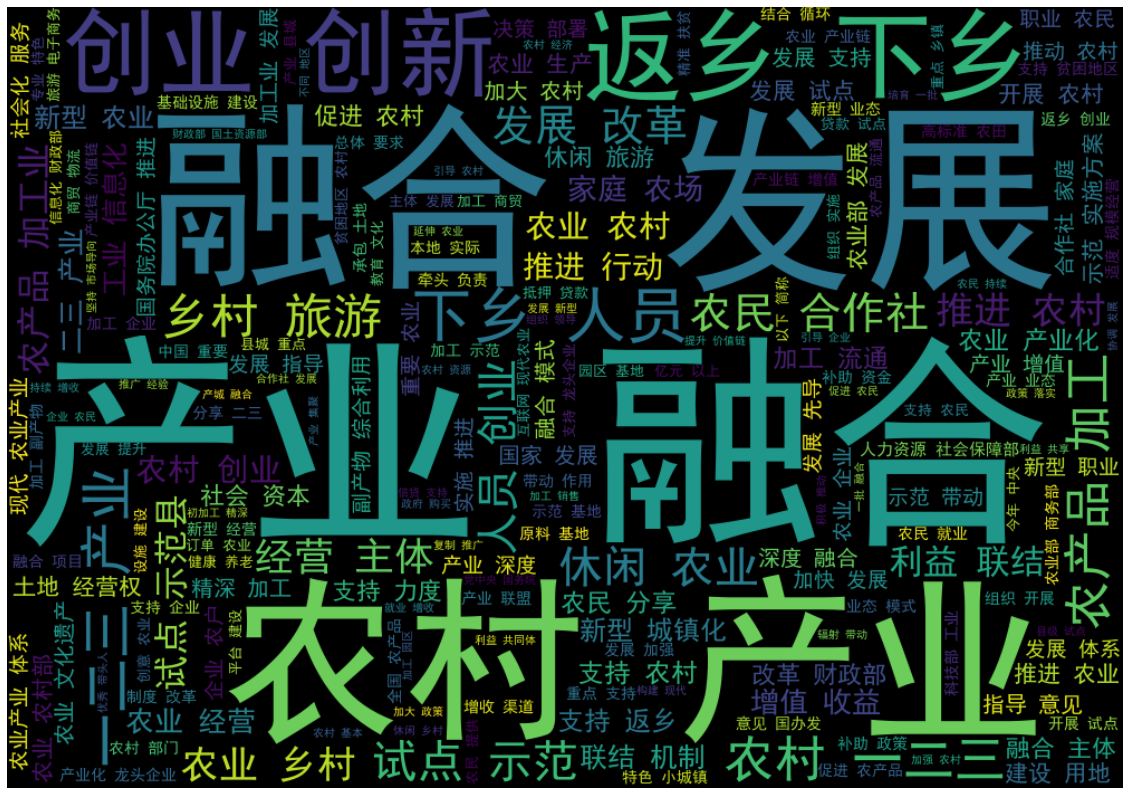

In [13]:
# 展示结果
fig = plt.figure(figsize=(20, 100))
plt.imshow(w, interpolation='bilinear')
plt.axis("off")
plt.show()

## 动态词云图

In [14]:
def wordcloud_diamond() -> WordCloud:
    words = items
    c = (
        WordCloud()
        .add("", words, word_size_range=[20, 100], shape=SymbolType.DIAMOND)
        .set_global_opts(title_opts=opts.TitleOpts(title="农村产业融合政策法规词云图"))
    )
    return c


wordcloud_diamond().render('04_农村产业融合政策法规词云图.html')
wordcloud_diamond().render_notebook()